<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-keras-functional-API" data-toc-modified-id="The-keras-functional-API-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The keras functional API</a></span></li><li><span><a href="#Two-input-network-using-categorial-Embeddings,-shared-Layers-and-Merge-layers" data-toc-modified-id="Two-input-network-using-categorial-Embeddings,-shared-Layers-and-Merge-layers-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Two input network using categorial Embeddings, shared Layers and Merge layers</a></span></li><li><span><a href="#Multiple-Inputs" data-toc-modified-id="Multiple-Inputs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Multiple Inputs</a></span></li><li><span><a href="#Multiple-Outputs" data-toc-modified-id="Multiple-Outputs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multiple Outputs</a></span></li></ul></div>

In [10]:
import pandas as pd
from  matplotlib import pyplot as plt
%matplotlib inline

In [11]:
df1 = pd.read_csv('basketball_data/games_season.csv')
df2 = pd.read_csv('basketball_data/games_tourney.csv')

In [12]:
df1.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [13]:
df2.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [14]:
#import qgrid
#qgrid_widget = qgrid.show_grid(df1[:10],show_toolbar=True)
#qgrid_widget
#qgrid_widget.get_changed_df()

#  The keras functional API

* learn basics of keras functional API
* create a network -> fit to the data -> make predictions

Text(0.5,1,'Histogram of Score Differences')

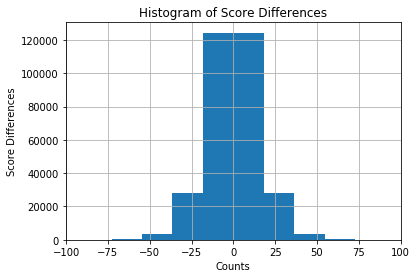

In [15]:
df1['score_diff'].hist()
plt.xlabel('Counts')
plt.ylabel('Score Differences')
plt.title('Histogram of Score Differences')

Text(0.5,1,'Histogram of Seed Differences')

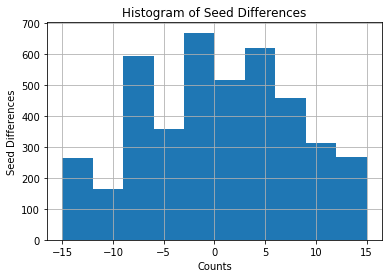

In [16]:
df2['seed_diff'].hist()
plt.xlabel('Counts')
plt.ylabel('Seed Differences')
plt.title('Histogram of Seed Differences')

In [17]:
# simple one-input network 
from keras.layers import Input, Dense
from keras.models import Model 
from keras.utils import plot_model 

#network artifact
input_tensor = Input(shape=(1,)) #input 
#output_layer = Dense(1) #dense layer
#output_tensor = output_layer(input_tensor) #connect dense layer to input tensor
# above 2 lines combined into one: 
output_tensor = Dense(1)(input_tensor)
model = Model(input_tensor,output_tensor)

#compile
model.compile(optimizer='adam',loss='mean_absolute_error')
print('Model summary: ',model.summary())

#plot model
#plot_model(model,to_file='model.png')
#display image
#data = plt.imread('model.png')
#plt.imshow(data)

#fit the model
X_train = df2[:3800]
y_train = df2[:3800]
model.fit(X_train['seed_diff'],y_train['score_diff'],
         epochs=1, batch_size=128, validation_split=0.1,verbose=True)

/Users/Mitul/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Model summary:  None
Train on 3420 samples, validate on 380 samples
Epoch 1/1
3420/3420 [==============================] - 0s 127us/step - loss: 13.9746 - val_loss: 12.5808


In [18]:
#model evaluate
X_test = df2[3800:]
y_test = df2[3800:]
model.evaluate(X_test['seed_diff'],y_test['score_diff'])

434/434 [==============================] - 0s 35us/step


13.599331464635611

# Two input network using categorial Embeddings, shared Layers and Merge layers

* create 2 input network 
* dealing with categorial embeddings 
* learn about shared layers and merge layers to join multiple inputs to a single output

In [19]:
df1.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [20]:
from keras.layers import Embedding, Flatten
from numpy import unique

n_teams = unique(df1[['team_1','team_2']]).shape[0]

#model artifact
teamid_in = Input(shape=(1,))

#embedding layer
team_lookup = Embedding(input_dim=n_teams,output_dim=1
                       ,input_length=1,name='Team-Strength')

#look up inputs
strength_lookup = team_lookup(teamid_in)

#flatten
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

In [21]:
# since we have 2 teams, lets creat input layers for each
team_in_1 = Input(shape=(1,),name='Team-1-In')
team_in_2 = Input(shape=(1,),name='Team-2-In')

#look up teams in the model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

#running the above 2 lines- now the model knows the strength of each team
# Import the Subtract layer from keras
from keras.layers import Subtract

# Create a subtract layer using the inputs from the previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile('adam', 'mean_absolute_error')

#fit the model
# Get the team_1 column from the regular season data
input_1 = df1['team_1']

# Get the team_2 column from the regular season data
input_2 = df1['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1,input_2],df1['score_diff'],
          epochs=1,
          batch_size=2048,
          validation_split=0.1,
          verbose=True)

#Evaluate the model on the tournament test data
# Get team_1 from the tournament data
input_1 = df2['team_1']

# Get team_2 from the tournament data
input_2 = df2['team_2']

# Evaluate the model using these inputs
model.evaluate([input_1, input_2], df2['score_diff'])

Train on 280960 samples, validate on 31218 samples
Epoch 1/1
4234/4234 [==============================] - 0s 14us/step


11.680415491816792

# Multiple Inputs 

* 3 or more inputs
* understand keras summary, plot functions to understand parameters of the model and topology of the network.

In [26]:
team_strength_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
Team-Strength (Embedding)    (None, 1, 1)              10888     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


In [29]:
from keras.layers import Concatenate

# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Fit the model to the games_season dataset
model.fit([df1.team_1, df1.team_2, df1.home],
          df1.score_diff,
          epochs=1,
          verbose=True,
          validation_split=0.1,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
model.evaluate([df2.team_1,df2.team_2 
,df2.home], df2.score_diff)

Train on 280960 samples, validate on 31218 samples
Epoch 1/1
4234/4234 [==============================] - 0s 18us/step


11.688425564574475

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Model)     (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
Home-In (InputLayer)            (None, 1)            0                                            
__________

In [32]:
# Plot the model
#plot_model(model, to_file='model.png')

# Display the image
#data = plt.imread('model.png')
#plt.imshow(data)
# Predict
df2['pred'] = model.predict([df2.team_1,df2.team_2, df2.home])

In [44]:
# alternate method to create models only for purely numeric data
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

X_train = df2[:3168]
y_train = df2[:3168]
X_test = df2[3168:]
y_test = df2[3168:]

# Fit the model
model.fit(X_train[['home', 'seed_diff', 'pred']],
          y_train['score_diff'],
          epochs=1,
          verbose=True)

# Evaluate the model on the games_tourney_test dataset
model.evaluate(X_test[['home','seed_diff','pred']], 
               y_test['score_diff'])

Epoch 1/1
1066/1066 [==============================] - 0s 62us/step


9.078073226041239

In [42]:
df2.shape

(4234, 10)

# Multiple Outputs

* 3 or more outputs
* solve regression problem with multiple targets
* solve classification problem simultaneously

In [46]:
# Define the input
input_tensor = Input(shape=(2,))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile('adam', 'mean_absolute_error')

# Fit the model
model.fit(X_train[['seed_diff', 'pred']],
          y_train[['score_1', 'score_2']],
          verbose=True,
          epochs=100,
          batch_size=16384)

# Print the model's weights
print(model.get_weights())

# Print the column means of the training data
print((X_train).mean())

# Evaluate the model on the tournament test data
model.evaluate(X_test[['seed_diff', 'pred']],
y_test[['score_1', 'score_2']])

Epoch 1/100
3168/3168 [==============================] - 0s 84us/step - loss: 71.9904
Epoch 2/100
3168/3168 [==============================] - 0s 1us/step - loss: 71.9892
Epoch 3/100
3168/3168 [==============================] - 0s 1us/step - loss: 71.9879
Epoch 4/100
3168/3168 [==============================] - 0s 2us/step - loss: 71.9867
Epoch 5/100
3168/3168 [==============================] - 0s 1us/step - loss: 71.9855
Epoch 6/100
3168/3168 [==============================] - 0s 1us/step - loss: 71.9842
Epoch 7/100
3168/3168 [==============================] - 0s 2us/step - loss: 71.9830
Epoch 8/100
3168/3168 [==============================] - 0s 1us/step - loss: 71.9818
Epoch 9/100
3168/3168 [==============================] - 0s 1us/step - loss: 71.9806
Epoch 10/100
3168/3168 [==============================] - 0s 2us/step - loss: 71.9793
Epoch 11/100
3168/3168 [==============================] - 0s 2us/step - loss: 71.9781
Epoch 12/100
3168/3168 [==============================] - 0s 1

Epoch 97/100
3168/3168 [==============================] - 0s 2us/step - loss: 71.8722
Epoch 98/100
3168/3168 [==============================] - 0s 2us/step - loss: 71.8710
Epoch 99/100
3168/3168 [==============================] - 0s 1us/step - loss: 71.8698
Epoch 100/100
3168/3168 [==============================] - 0s 3us/step - loss: 71.8685
[array([[ 0.31569865,  0.14196526],
       [-0.5557531 ,  0.07560513]], dtype=float32), array([0.10009165, 0.10009165], dtype=float32)]
season        1997.045455
team_1        5546.025568
team_2        5546.025568
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.912247
score_2         71.912247
won              0.500000
pred             0.229734
dtype: float64
1066/1066 [==============================] - 0s 113us/step


68.78151002923275

In [48]:
# Create an input layer with 2 columns
input_tensor = Input((2,))

# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output (use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

# Import the Adam optimizer
from keras.optimizers import Adam

# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], optimizer=Adam(lr=0.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(X_train[['seed_diff', 'pred']],
          [X_train[['score_diff']], X_train[['won']]],
          epochs=10,
          verbose=True,
          batch_size=16384)

# Print the model weights
print(model.get_weights())

# Print the training data means
print(X_train.mean())

# Import the sigmoid function from scipy
from scipy.special import expit as sigmoid

# Weight from the model
weight = 0.14

# Print the approximate win probability of a predicted close game
print(sigmoid(1 * weight))

# Print the approximate win probability of a predicted blowout game
print(sigmoid(10 * weight))


# Evaluate the model on new data
model.evaluate(y_test[['seed_diff', 'pred']],
               [y_test[['score_diff']], y_test[['won']]])

Epoch 1/10
3168/3168 [==============================] - 1s 271us/step - loss: 9.9762 - dense_7_loss: 9.1687 - dense_8_loss: 0.8075
Epoch 2/10
3168/3168 [==============================] - 0s 2us/step - loss: 9.9644 - dense_7_loss: 9.1725 - dense_8_loss: 0.7919
Epoch 3/10
3168/3168 [==============================] - 0s 3us/step - loss: 9.9533 - dense_7_loss: 9.1766 - dense_8_loss: 0.7767
Epoch 4/10
3168/3168 [==============================] - 0s 2us/step - loss: 9.9432 - dense_7_loss: 9.1806 - dense_8_loss: 0.7626
Epoch 5/10
3168/3168 [==============================] - 0s 3us/step - loss: 9.9332 - dense_7_loss: 9.1829 - dense_8_loss: 0.7503
Epoch 6/10
3168/3168 [==============================] - 0s 5us/step - loss: 9.9234 - dense_7_loss: 9.1840 - dense_8_loss: 0.7394
Epoch 7/10
3168/3168 [==============================] - 0s 2us/step - loss: 9.9134 - dense_7_loss: 9.1835 - dense_8_loss: 0.7299
Epoch 8/10
3168/3168 [==============================] - 0s 2us/step - loss: 9.9034 - dense_7_lo

[9.885717241670132, 9.083277056409539, 0.8024402000219693]